In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu113\\python.exe'

# <font color="Red">マルチラベルで分類モデル作成<font>
## ニューラルネットワークを分岐させずにMulti-task learning

In [2]:
#import os
#gpu_num = "3"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [3]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21

import pathlib
#current_dir = pathlib.Path("__file__").resolve().parent
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

sys.path.append(r'C:\Users\shingo\Git\mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

%reload_ext autoreload
%autoreload 2

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file


## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

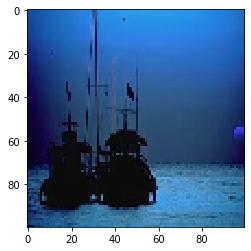

In [4]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()

plt.imshow(x_train[0])

### パラメータ設定
- 画像サイズ: 100x100
- エポック数: 10
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル: SEInceptionV3
    - 全結合層: 1層（各層のニューロンの数は1024。各層にdropoutを0.5倍、重みの初期値はhe_normal(He の正規分布)、L2正則化=1e-4）
    - 重みは全層学習させる（fine-tuningなし）
    - 出力層の活性化関数: sigmoid（マルチラベルなので）
    - 出力層の重みの初期値はzero
- オプティマイザ: SGD
    - 学習率: 0.01
- データ水増し
    - 画像の剪断（shear_range=0.2）
    - 拡大縮小（zoom_range=[0.5, 1.9]）
    - 回転（rotation_range=60）
    - 上下反転（horizontal_flip=True）
    - 左右反転（vertical_flip=True）
    - 画像の一部矩形領域を隠す（random_erasing)
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01 になるまで段階的に学習率下げる
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    

In [6]:
# 出力ディレクトリ
out_dir = r'D:\work\kaggle_data\multi_label_test'
os.makedirs(out_dir, exist_ok=True)

# batch_size
train_batch_size=50
valid_batch_size=50

# エポック数
epochs=10#250

# 入力層のサイズ
shape=[100, 100, 3]

# クラス数
num_classes=5
task_name_list=['desert', 'mountain', 'sea', 'sunset', 'trees']

# Fine-tuning する学習済みモデル
choice_model='EfficientNet'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']

# 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
trainable='all'# [249]

# GradCamでモデルの注目点を切りだす最後の畳み込み層
layer_name = 'top_activation' #'mixed10'

## 全結合層のパラメータ
# pooling方法
fcpool='GlobalAveragePooling2D'
# 全結像層
fcs = [1024]
# 全結合層のニューロンの数とdropout rate
drop, is_add_batchnorm, kernel_init, l2_rate = 0.5, True, 'he_normal', 1e-4

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# optimizer のパラメータ
choice_optim='sgd'
lr = 0.01
decay = 0.0

# GPUの数
gpu_num = '1'
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# ImageDataGenerator のデータ水増しオプション
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

## コールバックの設定
# keras.callbacks.ModelCheckpoint
check_monitor='val_loss' # val_loss最少になるモデルを保存する

# keras.callbacks.EarlyStopping
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100


gpu_count: 1


### モデル定義

In [16]:
model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , fcs=fcs
                                                        , fcpool=fcpool
                                                        , drop=drop, is_add_batchnorm=is_add_batchnorm, kernel_init=kernel_init, l2_rate=l2_rate
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        )
# オプティマイザ
optim = define_model.get_optimizers(choice_optim, lr=lr, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)

# モデルコンパイル
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy),
              optimizer=optim,
              metrics=['binary_accuracy', multi_loss.masked_accuracy])#, lr_metric])

# callback
cb = []

if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'best_model.h5'), monitor=check_monitor, save_best_only=True))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati , verbose=1))
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01まで下げるだけ
    cb.append(my_callback.cosine_annealing())
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(out_dir, 'learning_curve.png')))
    
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
print(cb)

----- model_param -----
output_dir = D:\work\kaggle_data\multi_label_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = EfficientNet all
fcs = [1024]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB3
input_shape: (100, 100, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 1024 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
[<keras.callbacks.TerminateOnNaN object at 0x0000017F17B6C4A8>, <keras.callbacks.ModelCheckpoint object at 0x0000017F02AE1668>, <keras.callbacks.EarlyStopping object at 0x0000017F019DB080>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x0000017F019DB2B0>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x0000017F01A5DEF0>, <model.my_callback.tsv_logger.<loca

In [17]:
# モデルのサマリー
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 40)   1080        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 50, 40)   160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 50, 40)   0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

__________________________________________________________________________________________________
block2a_project_bn (BatchNormal (None, 25, 25, 32)   128         block2a_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_expand_conv (Conv2D)    (None, 25, 25, 192)  6144        block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_expand_bn (BatchNormali (None, 25, 25, 192)  768         block2b_expand_conv[0][0]        
__________________________________________________________________________________________________
block2b_expand_activation (Acti (None, 25, 25, 192)  0           block2b_expand_bn[0][0]          
__________________________________________________________________________________________________
block2b_dwconv (DepthwiseConv2D (None, 25, 25, 192)  1728        block2b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 8)      1544        block3a_se_reshape[0][0]         
__________________________________________________________________________________________________
block3a_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block3a_se_reduce[0][0]          
__________________________________________________________________________________________________
block3a_se_excite (Multiply)    (None, 13, 13, 192)  0           block3a_activation[0][0]         
                                                                 block3a_se_expand[0][0]          
__________________________________________________________________________________________________
block3a_project_conv (Conv2D)   (None, 13, 13, 48)   9216        block3a_se_excite[0][0]          
__________________________________________________________________________________________________
block3a_pr

block4a_dwconv (DepthwiseConv2D (None, 7, 7, 288)    2592        block4a_expand_activation[0][0]  
__________________________________________________________________________________________________
block4a_bn (BatchNormalization) (None, 7, 7, 288)    1152        block4a_dwconv[0][0]             
__________________________________________________________________________________________________
block4a_activation (Activation) (None, 7, 7, 288)    0           block4a_bn[0][0]                 
__________________________________________________________________________________________________
block4a_se_squeeze (GlobalAvera (None, 288)          0           block4a_activation[0][0]         
__________________________________________________________________________________________________
block4a_se_reshape (Reshape)    (None, 1, 1, 288)    0           block4a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4a_se

block4c_add (Add)               (None, 7, 7, 96)     0           block4c_drop[0][0]               
                                                                 block4b_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_conv (Conv2D)    (None, 7, 7, 576)    55296       block4c_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_bn (BatchNormali (None, 7, 7, 576)    2304        block4d_expand_conv[0][0]        
__________________________________________________________________________________________________
block4d_expand_activation (Acti (None, 7, 7, 576)    0           block4d_expand_bn[0][0]          
__________________________________________________________________________________________________
block4d_dwconv (DepthwiseConv2D (None, 7, 7, 576)    5184        block4d_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block5a_se_reduce (Conv2D)      (None, 1, 1, 24)     13848       block5a_se_reshape[0][0]         
__________________________________________________________________________________________________
block5a_se_expand (Conv2D)      (None, 1, 1, 576)    14400       block5a_se_reduce[0][0]          
__________________________________________________________________________________________________
block5a_se_excite (Multiply)    (None, 7, 7, 576)    0           block5a_activation[0][0]         
                                                                 block5a_se_expand[0][0]          
__________________________________________________________________________________________________
block5a_project_conv (Conv2D)   (None, 7, 7, 136)    78336       block5a_se_excite[0][0]          
__________________________________________________________________________________________________
block5a_pr

block5d_dwconv (DepthwiseConv2D (None, 7, 7, 816)    20400       block5d_expand_activation[0][0]  
__________________________________________________________________________________________________
block5d_bn (BatchNormalization) (None, 7, 7, 816)    3264        block5d_dwconv[0][0]             
__________________________________________________________________________________________________
block5d_activation (Activation) (None, 7, 7, 816)    0           block5d_bn[0][0]                 
__________________________________________________________________________________________________
block5d_se_squeeze (GlobalAvera (None, 816)          0           block5d_activation[0][0]         
__________________________________________________________________________________________________
block5d_se_reshape (Reshape)    (None, 1, 1, 816)    0           block5d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5d_se

__________________________________________________________________________________________________
block6a_project_bn (BatchNormal (None, 4, 4, 232)    928         block6a_project_conv[0][0]       
__________________________________________________________________________________________________
block6b_expand_conv (Conv2D)    (None, 4, 4, 1392)   322944      block6a_project_bn[0][0]         
__________________________________________________________________________________________________
block6b_expand_bn (BatchNormali (None, 4, 4, 1392)   5568        block6b_expand_conv[0][0]        
__________________________________________________________________________________________________
block6b_expand_activation (Acti (None, 4, 4, 1392)   0           block6b_expand_bn[0][0]          
__________________________________________________________________________________________________
block6b_dwconv (DepthwiseConv2D (None, 4, 4, 1392)   34800       block6b_expand_activation[0][0]  
__________

__________________________________________________________________________________________________
block6d_se_reduce (Conv2D)      (None, 1, 1, 58)     80794       block6d_se_reshape[0][0]         
__________________________________________________________________________________________________
block6d_se_expand (Conv2D)      (None, 1, 1, 1392)   82128       block6d_se_reduce[0][0]          
__________________________________________________________________________________________________
block6d_se_excite (Multiply)    (None, 4, 4, 1392)   0           block6d_activation[0][0]         
                                                                 block6d_se_expand[0][0]          
__________________________________________________________________________________________________
block6d_project_conv (Conv2D)   (None, 4, 4, 232)    322944      block6d_se_excite[0][0]          
__________________________________________________________________________________________________
block6d_pr

__________________________________________________________________________________________________
block7a_expand_bn (BatchNormali (None, 4, 4, 1392)   5568        block7a_expand_conv[0][0]        
__________________________________________________________________________________________________
block7a_expand_activation (Acti (None, 4, 4, 1392)   0           block7a_expand_bn[0][0]          
__________________________________________________________________________________________________
block7a_dwconv (DepthwiseConv2D (None, 4, 4, 1392)   12528       block7a_expand_activation[0][0]  
__________________________________________________________________________________________________
block7a_bn (BatchNormalization) (None, 4, 4, 1392)   5568        block7a_dwconv[0][0]             
__________________________________________________________________________________________________
block7a_activation (Activation) (None, 4, 4, 1392)   0           block7a_bn[0][0]                 
__________

In [18]:
# モデルのレイヤー名と番号
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1

0 input_2
1 stem_conv
2 stem_bn
3 stem_activation
4 block1a_dwconv
5 block1a_bn
6 block1a_activation
7 block1a_se_squeeze
8 block1a_se_reshape
9 block1a_se_reduce
10 block1a_se_expand
11 block1a_se_excite
12 block1a_project_conv
13 block1a_project_bn
14 block1b_dwconv
15 block1b_bn
16 block1b_activation
17 block1b_se_squeeze
18 block1b_se_reshape
19 block1b_se_reduce
20 block1b_se_expand
21 block1b_se_excite
22 block1b_project_conv
23 block1b_project_bn
24 block1b_drop
25 block1b_add
26 block2a_expand_conv
27 block2a_expand_bn
28 block2a_expand_activation
29 block2a_dwconv
30 block2a_bn
31 block2a_activation
32 block2a_se_squeeze
33 block2a_se_reshape
34 block2a_se_reduce
35 block2a_se_expand
36 block2a_se_excite
37 block2a_project_conv
38 block2a_project_bn
39 block2b_expand_conv
40 block2b_expand_bn
41 block2b_expand_activation
42 block2b_dwconv
43 block2b_bn
44 block2b_activation
45 block2b_se_squeeze
46 block2b_se_reshape
47 block2b_se_reduce
48 block2b_se_expand
49 block2b_se_exci

### データ管理クラス定義
- d_cls.X_train: train set の画像データ（d_cls.X_train.shape:[11764, 331, 331, 3]）
- d_cls.X_valid: validation set の画像データ（d_cls.X_valid.shape:[296, 331, 331, 3]）
- d_cls.X_test: test set の画像データ（d_cls.X_test.shape:[647, 331, 331, 3]）
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [7]:
%%time
d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.X_train = x_train
d_cls.y_train = y_train
d_cls.X_valid = x_test
d_cls.y_valid = y_test

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x000001BE8AA98E18>}
Wall time: 160 ms


(<keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x1be9b1e4e80>,
 <keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x1be8aacc0b8>)

### 学習実行

In [20]:
%%time
model.fit_generator(d_cls.train_gen
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=d_cls.valid_gen
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb
                    , verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 22s - loss: 0.7613 - binary_accuracy: 0.7536 - masked_accuracy: 0.7536 - val_loss: 0.7184 - val_binary_accuracy: 0.7535 - val_masked_accuracy: 0.7535
Epoch 2/10
 - 8s - loss: 0.6925 - binary_accuracy: 0.7671 - masked_accuracy: 0.7671 - val_loss: 0.6689 - val_binary_accuracy: 0.7855 - val_masked_accuracy: 0.7855
Epoch 3/10
 - 8s - loss: 0.6482 - binary_accuracy: 0.7953 - masked_accuracy: 0.7952 - val_loss: 0.6163 - val_binary_accuracy: 0.8155 - val_masked_accuracy: 0.8155
Epoch 4/10
 - 8s - loss: 0.6135 - binary_accuracy: 0.8156 - masked_accuracy: 0.8156 - val_loss: 0.5824 - val_binary_accuracy: 0.8350 - val_masked_accuracy: 0.8350
Epoch 5/10
 - 8s - loss: 0.5891 - binary_accuracy: 0.8324 - masked_accuracy: 0.8324 - val_loss: 0.5598 - val_binary_accuracy: 0.8440 - val_masked_accuracy: 0.8440
Epoch 6/10
 - 8s - loss: 0.5686 - binary_accuracy: 0.8388 - masked_accuracy: 0.8387 - val_loss: 0.5455 - val_binary_accuracy: 0.8570 - v

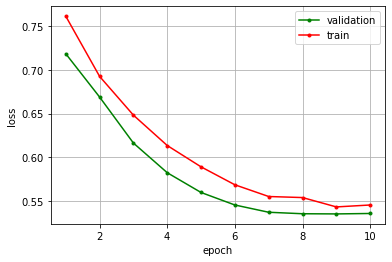

<Figure size 432x288 with 0 Axes>

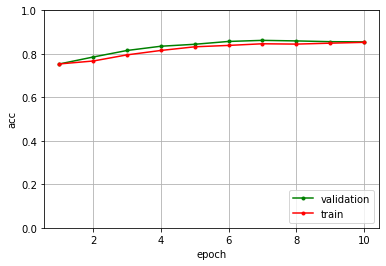

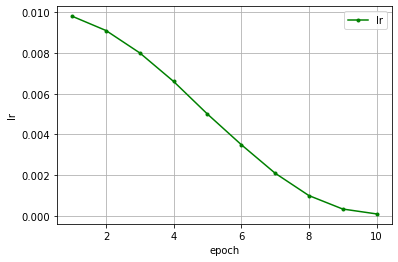

<Figure size 432x288 with 0 Axes>

In [21]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
#plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))
plot_log.plot_results(out_dir, os.path.join(out_dir, 'tsv_logger.tsv'))

### 推論実行

### test set（今回はtest set なし）
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/test ディレクトリに出力

In [22]:
#%%time
## -------- 推論 --------
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 推論結果出力先
#out_predict_dir = os.path.join(out_dir, 'predict/test')
#
## 出力層のニューラルネットワークに分岐がない場合のpredict
#y_test_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)
#
## -------- 混同行列 --------
## 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
#classes = [0,1,-1]
#
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
#conf_matrix.binary_multi_confmx(classes, y_test_list, y_pred_list, out_predict_dir)

In [23]:
## -------- ROC_AUC --------
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
#roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list)

### test set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

In [24]:
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 3次元numpy.array型の画像データ（*1./255.前）
#x = d_cls.X_test[0]*255.0
#input_img_name = 'test0'
#
#y_true = d_cls.y_test[0]
#
## 1画像について各タスクのGradCamを計算
#grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### test set 全件GradCam実行（十数時間かかる）

In [25]:
#%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test_all')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
#for i,  x in enumerate(d_cls.X_test):
#    # 3次元numpy.array型の画像データ（*1./255.前）
#    x = x*255.0
#
#    # ファイル名
#    file_path = test_files[test_files.index[i]]# test_filesはindexが0始まりではないので.index[i]で要素アクセス
#    input_img_name = os.path.basename(file_path)
#    print('input_img_name:', input_img_name)
#    
#    # 正解ラベル
#    y_true = d_cls.y_test[i]
#
#    # 1画像について各タスクのGradCamを計算
#    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])
#
## 確認用に1枚表示
#plt.figure(figsize=(6, 4))
#plt.imshow(grad_cam_img)
#plt.show()

In [16]:
model_EfficientNetB3_path = os.path.join(out_dir, 'best_model.h5')
model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , fcs=fcs
                                                        , fcpool=fcpool
                                                        , drop=drop, is_add_batchnorm=is_add_batchnorm, kernel_init=kernel_init, l2_rate=l2_rate
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        )
model.summary()

----- model_param -----
output_dir = D:\work\kaggle_data\multi_label_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = EfficientNet all
fcs = [1024]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
n_multitask = 1
EfficientNetB3
input_shape: (100, 100, 3)
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 1024 0.5 True he_normal 0.0001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 40)   1080        input_3[0][0]                    
________________

__________________________________________________________________________________________________
block2a_se_excite (Multiply)    (None, 25, 25, 144)  0           block2a_activation[0][0]         
                                                                 block2a_se_expand[0][0]          
__________________________________________________________________________________________________
block2a_project_conv (Conv2D)   (None, 25, 25, 32)   4608        block2a_se_excite[0][0]          
__________________________________________________________________________________________________
block2a_project_bn (BatchNormal (None, 25, 25, 32)   128         block2a_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_expand_conv (Conv2D)    (None, 25, 25, 192)  6144        block2a_project_bn[0][0]         
__________________________________________________________________________________________________
block2b_ex

block3a_activation (Activation) (None, 13, 13, 192)  0           block3a_bn[0][0]                 
__________________________________________________________________________________________________
block3a_se_squeeze (GlobalAvera (None, 192)          0           block3a_activation[0][0]         
__________________________________________________________________________________________________
block3a_se_reshape (Reshape)    (None, 1, 1, 192)    0           block3a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3a_se_reduce (Conv2D)      (None, 1, 1, 8)      1544        block3a_se_reshape[0][0]         
__________________________________________________________________________________________________
block3a_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block3a_se_reduce[0][0]          
__________________________________________________________________________________________________
block3a_se

__________________________________________________________________________________________________
block4a_expand_bn (BatchNormali (None, 13, 13, 288)  1152        block4a_expand_conv[0][0]        
__________________________________________________________________________________________________
block4a_expand_activation (Acti (None, 13, 13, 288)  0           block4a_expand_bn[0][0]          
__________________________________________________________________________________________________
block4a_dwconv (DepthwiseConv2D (None, 7, 7, 288)    2592        block4a_expand_activation[0][0]  
__________________________________________________________________________________________________
block4a_bn (BatchNormalization) (None, 7, 7, 288)    1152        block4a_dwconv[0][0]             
__________________________________________________________________________________________________
block4a_activation (Activation) (None, 7, 7, 288)    0           block4a_bn[0][0]                 
__________

__________________________________________________________________________________________________
block4c_project_bn (BatchNormal (None, 7, 7, 96)     384         block4c_project_conv[0][0]       
__________________________________________________________________________________________________
block4c_drop (FixedDropout)     (None, 7, 7, 96)     0           block4c_project_bn[0][0]         
__________________________________________________________________________________________________
block4c_add (Add)               (None, 7, 7, 96)     0           block4c_drop[0][0]               
                                                                 block4b_add[0][0]                
__________________________________________________________________________________________________
block4d_expand_conv (Conv2D)    (None, 7, 7, 576)    55296       block4c_add[0][0]                
__________________________________________________________________________________________________
block4d_ex

block5a_activation (Activation) (None, 7, 7, 576)    0           block5a_bn[0][0]                 
__________________________________________________________________________________________________
block5a_se_squeeze (GlobalAvera (None, 576)          0           block5a_activation[0][0]         
__________________________________________________________________________________________________
block5a_se_reshape (Reshape)    (None, 1, 1, 576)    0           block5a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5a_se_reduce (Conv2D)      (None, 1, 1, 24)     13848       block5a_se_reshape[0][0]         
__________________________________________________________________________________________________
block5a_se_expand (Conv2D)      (None, 1, 1, 576)    14400       block5a_se_reduce[0][0]          
__________________________________________________________________________________________________
block5a_se

__________________________________________________________________________________________________
block5d_expand_bn (BatchNormali (None, 7, 7, 816)    3264        block5d_expand_conv[0][0]        
__________________________________________________________________________________________________
block5d_expand_activation (Acti (None, 7, 7, 816)    0           block5d_expand_bn[0][0]          
__________________________________________________________________________________________________
block5d_dwconv (DepthwiseConv2D (None, 7, 7, 816)    20400       block5d_expand_activation[0][0]  
__________________________________________________________________________________________________
block5d_bn (BatchNormalization) (None, 7, 7, 816)    3264        block5d_dwconv[0][0]             
__________________________________________________________________________________________________
block5d_activation (Activation) (None, 7, 7, 816)    0           block5d_bn[0][0]                 
__________

__________________________________________________________________________________________________
block6a_se_excite (Multiply)    (None, 4, 4, 816)    0           block6a_activation[0][0]         
                                                                 block6a_se_expand[0][0]          
__________________________________________________________________________________________________
block6a_project_conv (Conv2D)   (None, 4, 4, 232)    189312      block6a_se_excite[0][0]          
__________________________________________________________________________________________________
block6a_project_bn (BatchNormal (None, 4, 4, 232)    928         block6a_project_conv[0][0]       
__________________________________________________________________________________________________
block6b_expand_conv (Conv2D)    (None, 4, 4, 1392)   322944      block6a_project_bn[0][0]         
__________________________________________________________________________________________________
block6b_ex

block6d_activation (Activation) (None, 4, 4, 1392)   0           block6d_bn[0][0]                 
__________________________________________________________________________________________________
block6d_se_squeeze (GlobalAvera (None, 1392)         0           block6d_activation[0][0]         
__________________________________________________________________________________________________
block6d_se_reshape (Reshape)    (None, 1, 1, 1392)   0           block6d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6d_se_reduce (Conv2D)      (None, 1, 1, 58)     80794       block6d_se_reshape[0][0]         
__________________________________________________________________________________________________
block6d_se_expand (Conv2D)      (None, 1, 1, 1392)   82128       block6d_se_reduce[0][0]          
__________________________________________________________________________________________________
block6d_se

__________________________________________________________________________________________________
block6f_add (Add)               (None, 4, 4, 232)    0           block6f_drop[0][0]               
                                                                 block6e_add[0][0]                
__________________________________________________________________________________________________
block7a_expand_conv (Conv2D)    (None, 4, 4, 1392)   322944      block6f_add[0][0]                
__________________________________________________________________________________________________
block7a_expand_bn (BatchNormali (None, 4, 4, 1392)   5568        block7a_expand_conv[0][0]        
__________________________________________________________________________________________________
block7a_expand_activation (Acti (None, 4, 4, 1392)   0           block7a_expand_bn[0][0]          
__________________________________________________________________________________________________
block7a_dw

__________________________________________________________________________________________________


In [17]:
model.load_weights(model_EfficientNetB3_path)

### validation set
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/validation ディレクトリに出力

y_pred.shape: (400, 5)
------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/validation\confusion_matrix
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       316
           1       0.92      0.29      0.44        84
          -1       0.00      0.00      0.00         0

   micro avg       0.84      0.84      0.84       400
   macro avg       0.59      0.43      0.45       400
weighted avg       0.86      0.84      0.81       400

Confusion matrix, without normalization


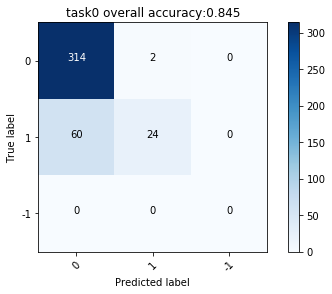

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/validation\confusion_matrix
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       305
           1       0.75      0.54      0.63        95
          -1       0.00      0.00      0.00         0

   micro avg       0.85      0.85      0.85       400
   macro avg       0.54      0.49      0.51       400
weighted avg       0.84      0.85      0.84       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

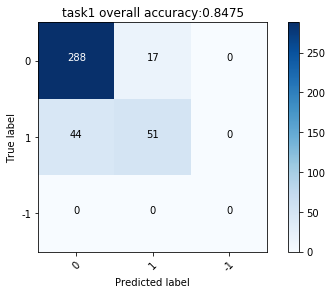

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/validation\confusion_matrix
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       297
           1       0.82      0.30      0.44       103
          -1       0.00      0.00      0.00         0

   micro avg       0.80      0.80      0.80       400
   macro avg       0.54      0.43      0.44       400
weighted avg       0.80      0.80      0.77       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

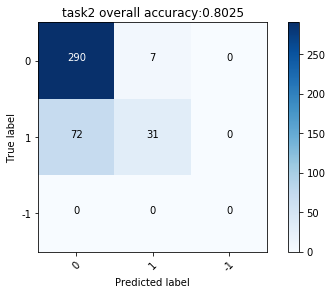

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/validation\confusion_matrix
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       313
           1       0.86      0.71      0.78        87
          -1       0.00      0.00      0.00         0

   micro avg       0.91      0.91      0.91       400
   macro avg       0.59      0.56      0.58       400
weighted avg       0.91      0.91      0.91       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

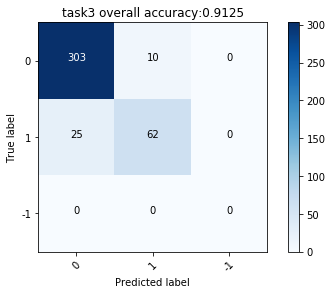

------------------------------------
out_dir: D:\work\kaggle_data\multi_label_test\predict/validation\confusion_matrix
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       274
           1       0.94      0.63      0.76       126
          -1       0.00      0.00      0.00         0

   micro avg       0.87      0.87      0.87       400
   macro avg       0.60      0.54      0.56       400
weighted avg       0.88      0.87      0.86       400

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

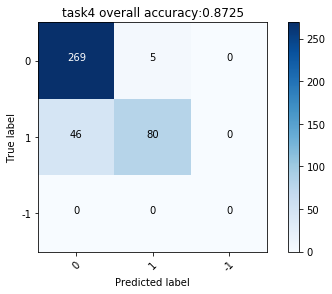

Wall time: 12.6 s


<Figure size 432x288 with 0 Axes>

In [18]:
%%time
# -------- 推論 --------
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/validation')

# 出力層のニューラルネットワークに分岐がない場合のpredict
y_valid_list, y_pred_list = base_predict.no_branch_set_predict(model, d_cls.X_valid, d_cls.y_valid, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_valid_list, y_pred_list, out_predict_dir)

------------------------------------
out_png: D:\work\kaggle_data\multi_label_test\predict/validation\ROC_curve.png
desert_roc_auc: 0.8920283303194695
mountain_roc_auc: 0.8905263157894737
sea_roc_auc: 0.8249158249158249
sunset_roc_auc: 0.9569608167162424
trees_roc_auc: 0.9291797010775111
mean_auc: 0.8976359705391945
std_auc: 0.04444942578091685


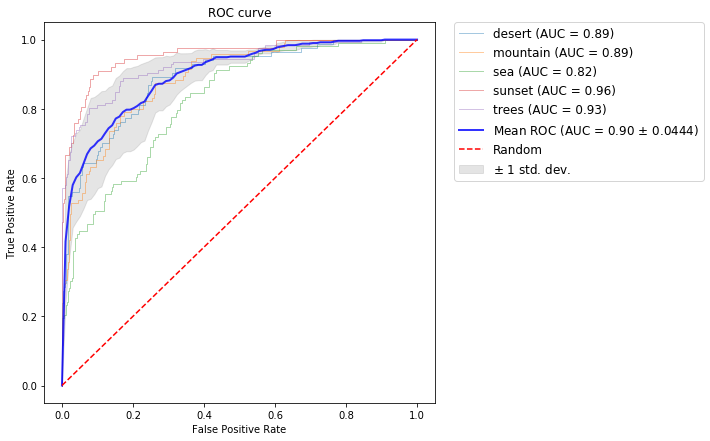

<Figure size 432x288 with 0 Axes>

In [19]:
# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_valid_list, y_pred_list
                  , task_name_list=task_name_list
                  )

### validation set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

Instructions for updating:
Use tf.cast instead.


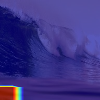

In [21]:
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation')

#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_valid[0]*255.0
input_img_name = 'valid0'

y_true = d_cls.y_valid[0]

# 1画像について各タスクのGradCamを計算
layer_name = 'top_activation'
grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### validation set 全件GradCam実行（数時間かかる）

In [22]:
%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation_all')

#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

for i,  x in enumerate(d_cls.X_valid):
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0
    
    # ファイル名
    file_path = validation_files[validation_files.index[i]]# validation_filesはindexが0始まりではないので.index[i]で要素アクセス
    input_img_name = os.path.basename(file_path)
    print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_valid[i]

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()

NameError: name 'validation_files' is not defined